Code adapted from 1. https://towardsdatascience.com/land-cover-classification-of-satellite-imagery-using-convolutional-neural-networks-91b5bb7fe808 and 2.https://github.com/PratyushTripathy/Landsat-Classification-Using-Neural-Network/blob/master/190826_TF2_builtupNeuralNetwork_tutorial_PT.py

In [50]:

from __future__ import print_function, division

import os
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# Import Python 3's print function and division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt

## Sklearn Libraries
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score,
            classification_report, recall_score, precision_recall_curve)
from pprint import pprint
from keras.models import Sequential


import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

### Preparing The Dataset


In [8]:
# Read in our satellite and label image
satellite_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/final_filled_l8_training_data.tif', gdal.GA_ReadOnly)
training_img = gdal.Open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/final_landcover_training_data.tif', gdal.GA_ReadOnly)


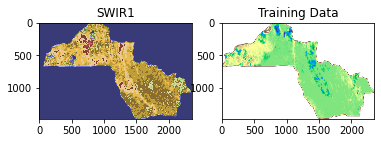

In [9]:

img = np.zeros((satellite_img.RasterYSize, satellite_img.RasterXSize, satellite_img.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(satellite_img.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = satellite_img.GetRasterBand(b + 1).ReadAsArray()
    
lbls = training_img.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.tab20b)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(lbls, cmap=plt.cm.terrain)
plt.title('Training Data')

plt.show()

In [42]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (lbls !=9).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(lbls[lbls !=9])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

#this is a quick numpy trick for flattening
X = img[lbls !=9]  # include 8th band, which is Fmask, for now
y = lbls[lbls !=9]


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))



We have 1322596 samples
The training data include 8 classes: [1 2 3 4 5 6 7 8]
Our X matrix is sized: (1322596, 7)
Our y array is sized: (1322596,)


In [45]:
#stratified k-cross validation to balance the classes
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_fin, y)

10

In [47]:
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  18595   18596   18597 ... 1322593 1322594 1322595] TEST: [     0      1      2 ... 206111 206112 206641]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [ 18595  18596  18597 ... 379338 379339 379340]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [ 27554  27555  27556 ... 545198 545199 545200]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [ 32127  32128  32129 ... 678038 678039 678040]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [ 36431  36432  36433 ... 789466 789467 789468]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [ 48237  48238  48239 ... 903431 903432 903441]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [  50207   50208   50209 ... 1011197 1011198 1011199]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [  53003   53004   53005 ... 1118295 1118296 1118297]
TRAIN: [      0       1       2 ... 1322593 1322594 1322595] TEST: [

In [ ]:
#define the CNN model 

model = Sequential(name = 'Salinas_CNN')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

In [ ]:
#train the cnn
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       batch_size = 256 , 
                       validation_data = (X_test, y_test), 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

In [ ]:
#accuracy and loss graph hist = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [ ]:
#performance
plt.figure(figsize = (10,7))

classes = ['Cropland', 'Mosaic Cropland', 'Mosaic Vegetation', 'Forest',
                         'Shrubland', 'Grassland', 'Urban', 'Water'
                                                           ]

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [ ]:
#classification report
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['Cropland', 'Mosaic Cropland', 'Mosaic Vegetation', 'Forest',
                         'Shrubland', 'Grassland', 'Urban', 'Water'
                                                           ]))

### Trainin the Neural Network

In [22]:
# Normalise the data (16-bit)
#X_train = X_train / 65535.0
#X_test = X_test / 65535

# Reshape the data
#X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [24]:
# Define the parameters of the model
#model = keras.Sequential([
    #keras.layers.Flatten(input_shape=(1, 7)),
    #keras.layers.Dense(14, activation='relu'),
    #keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [35]:
# Run the model
#model.fit(X_train, y_train, epochs=2)


In [ ]:
# Predict for test data 
#val = model.predict(X_test)
#yTestPredicted = yTestPredicted[:,1]

In [ ]:
# Calculate and display the error metrics
#val = (val>0.5).astype(int)
#cMatrix = confusion_matrix(y_test, val)
#pScore = precision_score(y_test, val)
#rScore = recall_score(y_test, val)
#f1Score = f1_score(y_test, val, average='weighted')#calculates f1 score for all labels and takes class imbalance into account

#print("Confusion matrix: for 14 nodes\n", cMatrix)
#print("\nP-Score: %.3f, R-Score: %.3f, F1-Score: %.3f" % (pScore, rScore, f1Score))